dict_keys(['__header__', '__version__', '__globals__', 'structural', 'funloc', 'masks', 'prior', 'labels', 'Y', 'X', 'description'])
['primary.nii', 'lh.V1d.nii', 'lh.V1v.nii', 'lh.V2d.nii', 'lh.V2v.nii', 'lh.V3d.nii', 'lh.V3v.nii', 'rh.V1d.nii', 'rh.V1v.nii', 'rh.V2d.nii', 'rh.V2v.nii', 'rh.V3d.nii', 'rh.V3v.nii']
['X: presented 28 x 28 images; Y: measured brain activity; prior: image prior; structural: structural MRI; funloc: localizer names; masks: localizer masks']
(100, 784)
(100, 3092)
(13,)
(110, 110, 37)
(110, 110, 37)
(2000, 784)


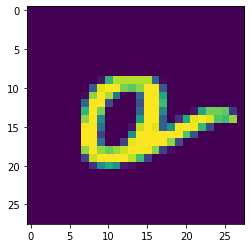

In [1]:
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt


dataset = loadmat('../handwritten_digits_in_fmri_dataset/69dataset.mat')
print(dataset.keys())
funloc = [list(name)[0] for name in dataset['funloc'][0]]
print(funloc)
print(dataset['description'])
print(dataset['X'].shape)
print(dataset['Y'].shape)
print(dataset['masks'][0].shape) # 13 masks total
print(dataset['masks'][0][0].shape) # the masks are for the structural image
print(dataset['structural'].shape)
print(dataset['prior'].shape)
plt.imshow(dataset['prior'][1500].reshape((28, 28)))


(20, 3092)
(80, 3092)


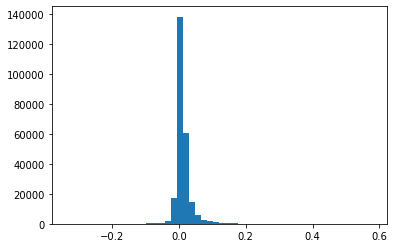

In [2]:
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt

# Load data
dataset = loadmat('../handwritten_digits_in_fmri_dataset/69dataset_split.mat')
NUM_VOXELS = dataset['y_test'].shape[1]
y_test = dataset['y_test']
y_train =  dataset['y_train']
print(y_test.shape)
print(y_train.shape)
plt.hist(y_train.flatten(), bins=50)
plt.show()
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test  = scaler.transform(y_test)
x_test = dataset['x_test']
x_train = dataset['x_train']

In [4]:
import sys
sys.path.append('..')
from pycaps.fmri_models import *
model_name = 'digits_encoder_112x112_test1'
# Load Model and make predictions
model = CapsEncoder(num_voxels=NUM_VOXELS, num_output_capsules=2, routing='dynamic', caps_act='squash')
#model = EncoderMach7(num_voxels=NUM_VOXELS, routing='dynamic', caps_act='squash')
#model = EncoderMach8(num_voxels=NUM_VOXELS)
print(model.class_name)
# model.load_weights('../trained_models/' + model_name + '/model_weights')
model.load_weights('../trained_models/' + model_name + '/best_ckpt')

CapsEncoder


In [5]:
import os
import yaml
from skimage.transform import resize
with open(os.path.join('../trained_models', model_name, 'train_config.yaml'), 'r') as file:
  training_params = yaml.load(file)

if 'image_size' in training_params.keys():
    if training_params['image_size'] != (28, 28):
        print('Resizing Images...')
        temp = []
        for image in x_test:
            temp.append(resize(image[:, :, 0], output_shape=training_params['image_size'], order=3))
        x_test = np.expand_dims(np.array(temp), axis=-1)
        temp = []
        for image in x_train:
            temp.append(resize(image[:, :, 0], output_shape=training_params['image_size'], order=3))
        x_train = np.expand_dims(np.array(temp), axis=-1)

/Users/scarere/venv/capsnet/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


Resizing Images...


In [6]:
import numpy as np

y_pred = model.call(x_test)
# y_train_pred = model.call(x_train)
# np.savetxt('../trained_models/' + model_name + '/y_pred.csv', y_pred, delimiter=',')
# np.savetxt('../trained_models/' + model_name + '/y_train_pred.csv', y_train_pred)

y_pred = np.loadtxt('../trained_models/' + model_name + '/y_pred.csv', delimiter=',')
# y_train_pred = np.loadtxt('../trained_models/' + model_name + '/y_train_pred.csv')
# plt.hist(y_pred.flatten())

(20, 112, 112, 1)


In [93]:
from scipy import stats
import tensorflow_probability as tfp

# Get correlations
voxel_corr = []
correlation = []
vc_p = []
for i in range(NUM_VOXELS):
    voxel_corr.append(stats.pearsonr(y_pred[:, i], y_test[:, i])[0])
    vc_p.append(stats.pearsonr(y_pred[:, i], y_test[:, i])[1])
for i in range(y_test.shape[0]):
    correlation.append(stats.pearsonr(y_test[i], y_pred[i])[0]) # returns correlation coefficient r and two tailed p-value

print('Mean Sample Correlation: ', np.mean(correlation))

print('Mean Voxel Correlation: ', np.mean(voxel_corr))

Mean Sample Correlation:  0.24376687927855328
Mean Voxel Correlation:  0.19491244076047362


In [24]:
dataset = loadmat('../handwritten_digits_in_fmri_dataset/69dataset.mat')
print(dataset['description'])
print(dataset.keys())
m_names = dataset['funloc'][0] #  names of functional  masks
masks = dataset['masks'][0] # 3d mri masks
y = dataset['Y'] # 1D vectors of voxel activation for each sampe
mri = dataset['structural']  # 3d mri volume
prior = dataset['prior'] # mnist  image priors used for recon
print(prior.shape)
print(mri.shape)
print(masks.shape)
print(masks[0].shape)
print(y.shape)
print(m_names.shape)

['X: presented 28 x 28 images; Y: measured brain activity; prior: image prior; structural: structural MRI; funloc: localizer names; masks: localizer masks']
dict_keys(['__header__', '__version__', '__globals__', 'structural', 'funloc', 'masks', 'prior', 'labels', 'Y', 'X', 'description'])
(2000, 784)
(110, 110, 37)
(13,)
(110, 110, 37)
(100, 3092)
(13,)


In [25]:
import matplotlib.pyplot as plt
mean = np.mean(y_train, axis=0)
diff = np.subtract(y_train, mean)
diff_mean = np.mean(abs(diff), axis=0)

diff = np.subtract(y_train_pred, mean)
diff_mean_2 = np.mean(abs(diff), axis=0)

diff = np.subtract(y_pred, mean)
diff_mean_3 = np.mean(abs(diff), axis=0)

print(np.mean(diff_mean))
print(np.mean(diff_mean_2))
print(np.mean(diff_mean_3))

stds = np.std(y_pred, axis=0)
print(np.mean(stds))
stdtest = np.std(y_test, axis=0)

0.7897168
0.20568483035177154
0.20191283850747999
0.22000211947177276


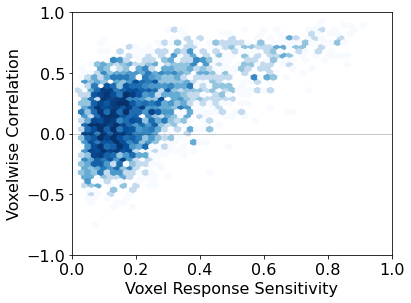

In [94]:
from matplotlib.ticker import LogFormatter
from matplotlib.colors import LogNorm
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
plt.figure(figsize=(6, 4.5))
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
plt.hexbin(stds, voxel_corr, cmap='Blues', gridsize=50, bins='log', vmax=15, extent=(0, 1, -1, 1))
plt.ylim(-1, 1)
plt.xlim(0, 1)
plt.xlabel('Voxel Response Sensitivity')
plt.ylabel('Voxelwise Correlation')
# cb = plt.colorbar(label='Number of Voxels', orientation='horizontal')
# cb.minorticks_off()
# cb.set_ticks([1, 11])
# cb.set_ticklabels(['0','10'])
# cb.set_ticks([3, 5, 7, 9], minor=True)
# cb.set_ticklabels(['2', '4', '6', '8'], minor=True)
#plt.savefig(os.path.join('models', model_name, 'corr-std.png'), bbox_inches='tight', facecolor='white')
plt.tight_layout()
plt.show()
matplotlib.rcParams.update({'font.size': 10})

0.7853956312267791


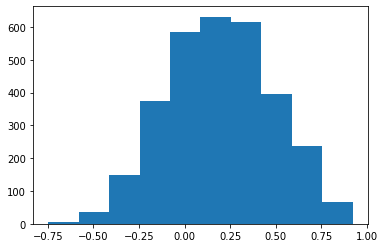

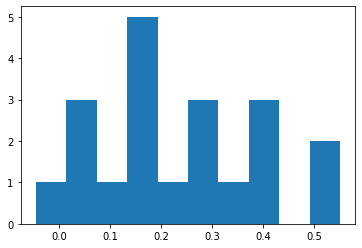

In [95]:
vc_sorted = np.sort(voxel_corr)
print(np.mean(vc_sorted[-100:]))
plt.hist(voxel_corr)
plt.figure()
plt.hist(correlation)
plt.show()

(3092,)


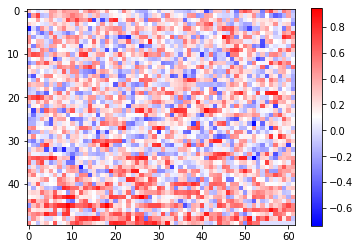

In [28]:
voxel_corr_2d = np.array(voxel_corr)
print(voxel_corr_2d.shape)
voxel_corr_2d.resize(3100)
voxel_corr_2d  = np.reshape(voxel_corr_2d, (50, 62))
plt.imshow(voxel_corr_2d, cmap='bwr')
plt.colorbar()
plt.show()

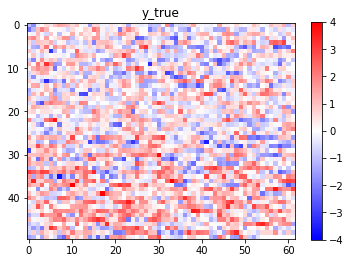

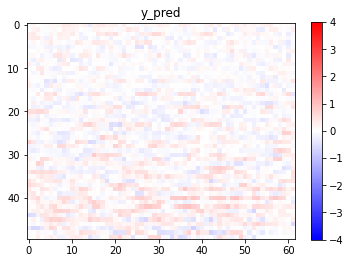

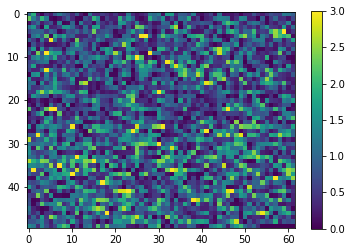

In [29]:
y_t_s2d  = y_test[0].copy()
y_t_s2d.resize(3100)
y_t_s2d = y_t_s2d.reshape((50,  62))

y_p_s2d  = y_pred[0].copy()
y_p_s2d.resize(3100)
y_p_s2d = y_p_s2d.reshape((50,  62))

plt.imshow(y_t_s2d, cmap='bwr')
plt.clim(-4, 4)
plt.colorbar()
plt.title('y_true')
plt.figure()
plt.imshow(y_p_s2d, cmap='bwr')
plt.title('y_pred')
plt.colorbar()
plt.clim(-4, 4)
plt.figure()
plt.imshow(abs(np.subtract(y_t_s2d,  y_p_s2d)))
plt.clim(-0, 3)
plt.colorbar()
plt.show()

dict_keys(['loss', 'mse', 'cosine_similarity', 'mae', 'val_loss', 'val_mse', 'val_cosine_similarity', 'val_mae', 'lr'])


(0.0, 100.0)

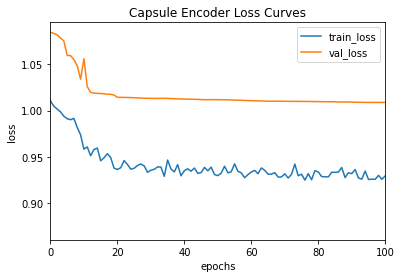

In [30]:
import json
with open('models/' + model_name + '/train-history.json', 'r')  as file:
    hist = json.load(file)

print(hist.keys())
plt.figure()
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.title('Capsule Encoder Loss Curves')

# plt.ylim(1.0, 1.2)
plt.xlim(left=0, right=100)

#plt.savefig('../trained_models/' + model_name + '/val_loss.png', bbox_inches='tight', facecolor='white')


In [36]:
from keras.losses import mean_squared_error, cosine_similarity, mean_absolute_error
from pycaps.losses import mse_cosine_loss
y_pred = y_pred.astype(np.float32)
y_test = y_test.astype(np.float32)
def combined_loss(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) +  0.1*cosine_similarity(y_true, y_pred)

loss = combined_loss(y_test, y_pred)
#loss = mse_cosine_loss(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
cos = cosine_similarity(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(np.mean(loss))
print(np.mean(mse))
print(np.mean(cos))
print(np.mean(mae))
print(np.argmin(hist['val_loss']))

print(np.mean(np.square(np.subtract(y_test, y_pred))))

0.9851326
1.0100603
-0.2492775
0.7918963
396
1.0100603


0.2370615292743835
-0.13806669225256887
575 18.596377749029756
59
0.2788686495156062 0.24094492120029712
0.27933557409361554 0.24384963659539044
0.5873849175042944 0.582295901818473
0.46455353343080874 0.45104930336692844


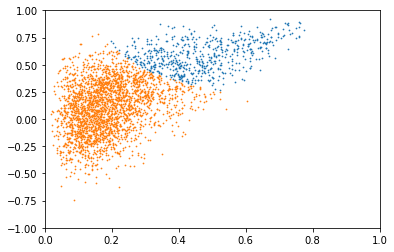

In [96]:
stds = np.std(y_pred, axis=0)
print(np.mean(stds))
voxel_corr = np.array(voxel_corr)
vc_p = np.array(vc_p)


stds_norm = stds/stdtest
vp = np.where(voxel_corr > 0)
vn = np.where(voxel_corr < 0)

vc_std = voxel_corr * stds
vc_std_norm = voxel_corr * stds_norm
print(np.min(vc_std))

vt = np.where(vc_std > abs(np.min(vc_std)))
vb = np.where(vc_std < abs(np.min(vc_std)))
print(len(vt[0]), len(vt[0])/NUM_VOXELS*100)
print(len(np.where(vc_p < 0.0001)[0]))
print(np.mean(vc_std[vt]), np.median(vc_std[vt]))
print(np.mean(vc_std_norm[vt]), np.median(vc_std_norm[vt]))
print(np.mean(voxel_corr[vt]), np.median(voxel_corr[vt]))
print(np.mean(stds[vt]), np.median(stds[vt]))

plt.scatter(stds[vt], voxel_corr[vt], s=0.5)
plt.scatter(stds[vb], voxel_corr[vb], s=0.5)
plt.ylim(-1, 1)
plt.xlim(0, 1)
plt.show()

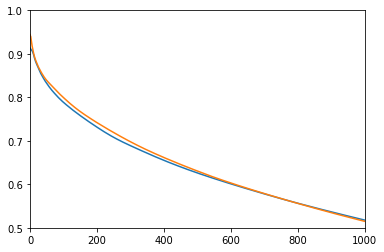

In [33]:
b_vc = np.loadtxt('models/digits_cnn_wide/gwide_vc.csv', delimiter=',')
mb = []
mc = []
for i in range(NUM_VOXELS):
    mb.append(np.mean(np.sort(b_vc)[NUM_VOXELS - i - 1:]))
    mc.append(np.mean(np.sort(voxel_corr)[NUM_VOXELS - i - 1:]))

plt.plot(mb)
plt.plot(mc)
plt.xlim(0, 1000)
plt.ylim(0.5, 1)
plt.show()

0.5523809523809524 0.44761904761904764
-0.6799339819373059
0.036460820399047564
0.7163948023363534


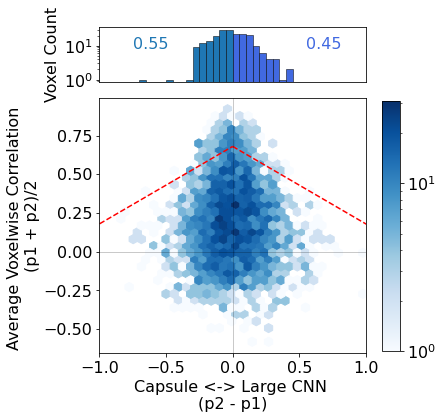

In [34]:
import matplotlib
import os
matplotlib.rcParams.update({'font.size': 16})
diff = b_vc - voxel_corr
avg = (b_vc + voxel_corr)/2
idx = np.where(np.maximum(b_vc, voxel_corr) > 0.6788)
l = (diff[idx] < 0).sum()/len(diff[idx])
r = (diff[idx] > 0).sum()/len(diff[idx])
print(l, r)
print(np.min(diff[idx]))
i = np.argmin(diff[idx])
print(b_vc[idx][i])
print(voxel_corr[idx][i])
fig = plt.figure(figsize=(6, 6))
gs = fig.add_gridspec(2, 2, width_ratios=(7, 1), height_ratios=(1.5, 7), hspace=0.1)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_c = fig.add_axes([.78,.13,.04,.58])

ax_histx.hist(diff[idx], bins=np.linspace(-1, 0, num=21), edgecolor='black', linewidth=0.5, color='tab:blue')
ax_histx.hist(diff[idx], bins=np.linspace(0, 1, num=21), edgecolor='black', linewidth=0.5, color='royalblue')
ax_histx.set_xlim(-1, 1)
ax_histx.tick_params(axis='x', which='both',
                bottom=False, labelbottom=False) 
ax_histx.set_yscale('log')
ax_histx.set_ylabel('Voxel Count')
ax_histx.text(-0.75, 8, '0.55', color='tab:blue')
ax_histx.text(0.55, 8, '0.45', color='royalblue')

hex = ax.hexbin(diff, avg, cmap='Blues', gridsize=30, bins='log')
plt.colorbar(hex, cax=ax_c)
ax.plot([-1.36, 0], [0, 0.68], '--', color='red')
ax.plot([0, 1.36], [0.68, 0], '--', color='red')
ax.axhline(y=0, color='black', alpha=0.3, linewidth=0.7)
ax.axvline(0, color='black', linestyle='-', alpha=0.3, linewidth=0.7)
ax.set_xlim(-1, 1)
ax.set_xlabel('Capsule <-> Large CNN \n(p2 - p1)')
ax.set_ylabel('Average Voxelwise Correlation \n(p1 + p2)/2')

plt.savefig(os.path.join('figures', 'st_plot_mnist.png'), bbox_inches='tight', facecolor='white')

plt.show()